In [1]:
import math
import numpy as np
import scipy
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from nptdms import TdmsFile
from findiff import Diff

In [2]:
# Parameters to set

# File
filename = r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2"
#EODLast3 - 41-46
offset = 426967933
num_files = 6
traces_per_file = 2

# Analysis
#4.464 micron

bin_nums = [50,100,150]
# (V^2/m^2) Found by fitting to PSD
V = 51.198e14
# V = 100e14
# (Hz) Found where low f noise begins to dominate in the PSD
high_pass = 100


In [3]:
def check_and_load_or_process(offset, *args,):
    results = process_folder(offset, *args)
    return results

def process_folder(offset, folder_name, data_col, num_traces, traces_per):
    results = []
    for i in range(num_traces):
        print("Reading ", folder_name, str(i))
        print("data_col ", data_col)
        for j in range(traces_per):
            result = process_file(folder_name, i, data_col, j, offset=offset)
            if result:
                results.append(result)
    return results

def process_file(folder_name, trace_num, data_col, trace_idx, offset):
    trace_num = trace_num + offset
    file_path = os.path.join(folder_name, "iter_" + str(trace_num) + ".tdms")
    series, args = read_tdms_file(file_path, data_col, trace_idx)

    return {
        "series": series,
        "args": args
    }

def read_tdms_file(file_path, data_col, trace_idx):
    tdms_file = TdmsFile.read(file_path)
    sample_rate = tdms_file["main"].properties.get("r", None)
    series = tdms_file["main"][data_col + "_" + str(trace_idx)]
    track_len = len(series.data)
    config_args = {
        "sampling_rate": sample_rate,
        "track_len": track_len
    }

    return series[:], config_args

def compute_VACF_time_domain(v_series):
    n = len(v_series)
    vacf = np.zeros(n)
    for lag in tqdm(range(n), desc="VACF Compute"):
        vacf[lag] = np.dot(v_series[:n - lag], v_series[lag:]) / (
                n - lag)
    return vacf

def get_velocity_higher_order(data, time, order):
    der = Diff(0, time[1] - time[0], acc = order)
    return der(data)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

def transfer_func(f):
    C = 1 / (10**-6*1000)
    x_c = 1j*f*2*np.pi
    A = 4000
    Sallen_key = x_c**2 / (x_c**2 + A*x_c + (1/3)*(A)**2)
    RC_high_pass = x_c / (x_c+C)
    return Sallen_key*RC_high_pass

In [4]:
results = check_and_load_or_process(offset, filename, "X", num_files, traces_per_file)
print(results[0]["args"])

traces = {bin_number: [] for bin_number in bin_nums}
v_traces = {bin_number: [] for bin_number in bin_nums}
vacfs = {bin_number: None for bin_number in bin_nums}
times = {bin_number: None for bin_number in bin_nums}

for bin_num in bin_nums:

    for trace in results:
        series = bin_data(trace["series"], bin_num)
        traces[bin_num].append(series)

    time = np.arange(0, len(traces[bin_num][0]))
    time = time * (bin_num/(results[0]['args']['sampling_rate']))
    times[bin_num] = time
    fs = results[0]['args']['sampling_rate']/bin_num


    # This number (100Hz) was found by visually inspecting the PSD, observing where the low f noise takes over (100Hz), and choosing lamda to be the magnitude of the transfer function at 100Hz so that the lamda term begins to take over when f > 100 Hz
    lda = np.abs(transfer_func(high_pass))

    traces_post_transfer = []

    for trace in traces[bin_num]:
        # apply the transfer and convert back
        freq_domain_data = scipy.fft.fft(trace)
        frequencies = scipy.fft.fftfreq(len(trace), time[1] - time[0])
        transfer = transfer_func(frequencies)

        freq_domain_data_transfer = (freq_domain_data*np.conj(transfer))/(np.real(transfer)**2 + np.imag(transfer)**2 + lda**2)
        data = np.fft.ifft(freq_domain_data_transfer)

        traces_post_transfer.append(np.real(data))

    v_squared = V
    v = math.sqrt(v_squared)

    traces_post_meter = []
    for trace in traces_post_transfer:
        traces_post_meter.append(np.real(trace / v))

    for trace in traces_post_meter:
        velocity = get_velocity_higher_order(trace, time, 2)
        v_traces[bin_num].append(velocity)

    all_vacf = []
    #
    # for series in traces_post_meter:
    #     v_series = np.diff(series) / np.diff(time)
    #     vacf = compute_VACF_time_domain(v_series)
    #     all_vacf.append(vacf)

    for trace in v_traces[bin_num]:
        vacf = compute_VACF_time_domain(trace)
        all_vacf.append(vacf)

    avg_vacf = np.mean(all_vacf, axis=0)
    vacfs[bin_num] = avg_vacf


Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 0
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 1
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 2
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 3
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 4
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 5
data_col  X
{'sampling_rate': 200000000.0, 'track_len': 8388608}


VACF Compute: 100%|██████████| 55924/55924 [00:01<00:00, 29280.22it/s]


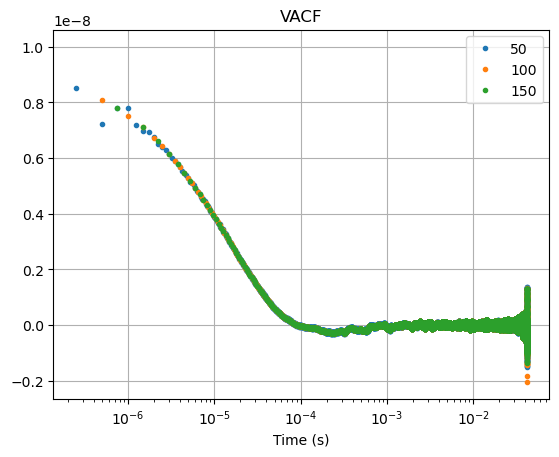

In [5]:
for bin_num in bin_nums:
    plt.plot(times[bin_num], vacfs[bin_num], ".", label=bin_num)
plt.xscale('log')
# plt.xlim(right=1e-5)
# plt.ylim(bottom=.75e-9, top = 1.15e-9)
plt.xlabel("Time (s)")
plt.title("VACF")
plt.legend()
plt.grid()

C:\Users\mcthu\AppData\Local\Temp\ipykernel_16424\1439193049.py:33: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  scipy.integrate.simps(SPD_func(frequencies, admit_function, m, k, r) * np.exp(-1j * frequencies * times[i]),


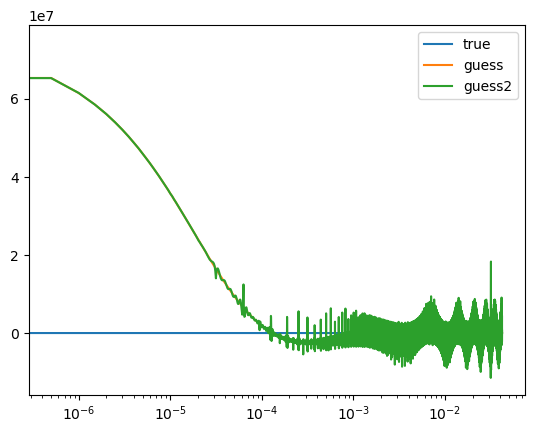

C:\Users\mcthu\AppData\Local\Temp\ipykernel_16424\1439193049.py:130: RuntimeWarning: invalid value encountered in log10
  log_vacf = np.log10(vacfs[100][1:])


a is 3e-06
k is 5e-05
v is 1e+16
a is 3e-06
k is 5.25e-05
v is 1e+16
a is 3.1500000000000003e-06
k is 5e-05
v is 1e+16
a is 3e-06
k is 5e-05
v is 1.05e+16
a is 3.1e-06
k is 5.1666666666666664e-05
v is 9500000000000000.0
a is 3.025e-06
k is 5.041666666666667e-05
v is 1.025e+16
a is 3e-06
k is 5.125e-05
v is 1e+16
a is 3.075e-06
k is 5e-05
v is 1e+16
a is 3e-06
k is 5e-05
v is 1.025e+16
a is 3.0500000000000004e-06
k is 5.083333333333332e-05
v is 9750000000000000.0
a is 3.0125000000000004e-06
k is 5.020833333333333e-05
v is 1.0125e+16
a is 3e-06
k is 5.0625e-05
v is 1e+16
a is 3.0375e-06
k is 5e-05
v is 1e+16
a is 3e-06
k is 5e-05
v is 1.0125e+16
a is 3.025e-06
k is 5.041666666666666e-05
v is 9875000000000000.0
a is 3.0062500000000002e-06
k is 5.010416666666667e-05
v is 1.00625e+16
a is 3e-06
k is 5.0312499999999996e-05
v is 1e+16
a is 3.01875e-06
k is 5e-05
v is 1e+16
a is 3e-06
k is 5e-05
v is 1.00625e+16
a is 3.0125000000000004e-06
k is 5.020833333333333e-05
v is 9937500000000000.0
a i

C:\Users\mcthu\AppData\Local\Temp\ipykernel_16424\1439193049.py:94: RuntimeWarning: Maximum number of iterations has been exceeded.
  optimal_parameters = minimize(


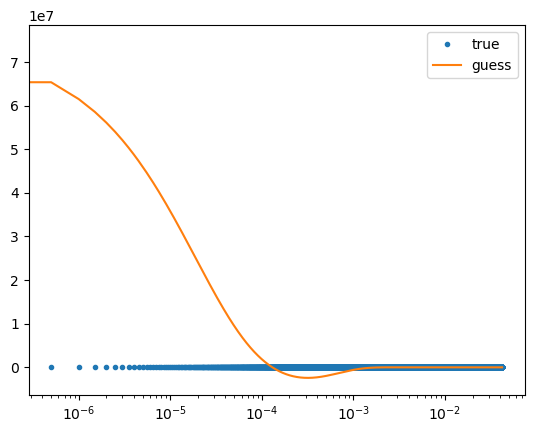

m 5.422451751949054e-13
k 5e-05
a 3e-06
v 1e+16


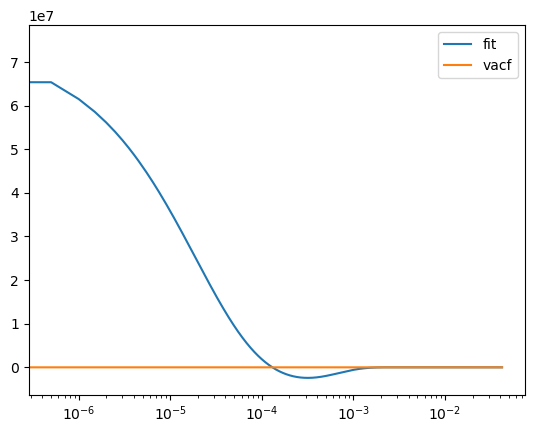

In [6]:
# Try VACF Fitting
from scipy.optimize import minimize
from scipy import constants
import scipy.interpolate as interp

# bounds = [(a_guess, a_guess), (m_guess, m_guess), (k_guess, k_guess), (v_guess, v_guess)]

eta = .3e-3
rho_f = 789


def incompressible_admittance(omega, m, k, r):
    return 1 / (-1j * omega * (m) + 6*math.pi*eta*r * (1 + np.sqrt(-1j * omega * ( (rho_f * r ** 2) / eta))) + k / (-1j * omega))

# This is from logans dissertation but does not agree with Jionyongs
def velocity_spectral_density(omega, admit_func, m, k, r):
    return 2 * constants.k * 293 * np.real(admit_func(omega, m, k, r))

# This assumes integration points
def VACF_admittance_fitting_func(admit_function, SPD_func, times, m, k, r, v):
    # times = times * (math.pi / 2)
    low_freq = np.linspace(1, 10 ** 4, 10000)
    mid_freq = np.linspace(10 ** 4, 10 ** 6, 10000)
    high_freq = np.linspace(10 ** 6, 10 ** 9, 10000)
    top_freq = np.linspace(10 ** 9, 10 ** 12, 10000)

    frequencies = np.concatenate((low_freq, mid_freq, high_freq, top_freq))

    ACF = np.zeros(len(times))

    for i in range(len(times)):
        ACF[i] = 2 * np.real(
            scipy.integrate.simps(SPD_func(frequencies, admit_function, m, k, r) * np.exp(-1j * frequencies * times[i]),
                                  frequencies)) / (2 * np.pi)

    return v*ACF

def VACF_fitting_func(t, m, K, r, V_):
    # t = t * (math.pi / 2)
    t_k = (6 * math.pi * r * eta) / K
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * math.pi * r * eta)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0

    a = t_p #+ (1 / 9.0) * t_f
    b = -np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a, b, c, d, e]
    # Find the roots

    roots = np.roots(coefficients)

    vacf_complex = (V_)*((constants.k * 293) / m) * sum(
        (z ** 3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots
    )
    return np.real(vacf_complex)


def VACF_fitting(t, avg_vacf, alpha, k_guess, a_guess, v_guess):
    # This function does the fitting (not for mass)

    def least_squares_func(x):
        print("a is " + str(x[1]))
        print("k is " + str(x[0]))
        print("v is " + str(x[2]))
        m_guess = 4400*(4/3)*np.pi*x[1]**3 + 789*.5*(4/3)*math.pi*x[1]**3
        vacf_model = VACF_fitting_func(t, m_guess, x[0], x[1], x[2])
        # WHY IS THERE A LENGTH DIFFERENCE

        residuals = (avg_vacf - vacf_model)  # Rescale to avoid underflow

        # Apply exponential weighting

        weights = np.exp(-alpha * t)
        weighted_residuals = weights * residuals * 1e15

        return np.sum(weighted_residuals ** 2)

    initial_guess = [k_guess, a_guess, v_guess]  # Scaled initial guess
    # bounds = [(k_guess*1e-3, k_guess*1e3), (a_guess*1e-3, a_guess*1e3),(v_guess*1e-3, v_guess*1e3)]
    options = {
        "disp": True,  # Display iteration details
        "maxiter": 5000,
        "xatol": 1e-15,
        "fatol": 1e-15
    }
    # Optimize using least squares
    optimal_parameters = minimize(
        least_squares_func,
        initial_guess,
        method='Nelder-Mead',
        # bounds=bounds,
        options=options
    )
    print(optimal_parameters.success, optimal_parameters.message)
    return optimal_parameters

a_guess = 3e-6
v_guess = 100e14
k_guess = 5e-5

m_start = 4400*(4/3)*np.pi*a_guess**3 + 789*.5*(4/3)*math.pi*a_guess**3

plt.plot(times[100], vacfs[100], label = "true")
plt.xscale('log')

vacf_model_initial = VACF_fitting_func(times[100], m_start, k_guess, a_guess, v_guess)
vacf_model_initial2 = VACF_admittance_fitting_func(incompressible_admittance, velocity_spectral_density, times[100], m_start, k_guess, a_guess, v_guess)

plt.plot(times[100], vacf_model_initial, label = "guess")
plt.plot(times[100], vacf_model_initial2, label = "guess2")

plt.legend()
plt.xscale('log')
plt.show()

# optimal_parameters = VACF_fitting(times[100][1:1000], vacfs[100][1:1000], 1000 , k_guess, a_guess, v_guess)
# m_final = 4400*(4/3)*np.pi*optimal_parameters.x[1]**3 + 789*.5*(4/3)*math.pi*optimal_parameters.x[1]**3
# VACF_fit = VACF_fitting_func(times[100][:1000], m_final, optimal_parameters.x[0], optimal_parameters.x[1], optimal_parameters.x[2])

# LOG FIT
###############################################################
log_times = np.log10(times[100][1:])
log_vacf = np.log10(vacfs[100][1:])
interp_func = interp.interp1d(log_times, log_vacf, kind="cubic", fill_value="extrapolate")
times_log = np.logspace(np.log10(times[100][1]), np.log10(times[100][-1]), 800)
vacf_log = 10**interp_func(np.log10(times_log))

optimal_parameters = VACF_fitting(times_log, vacf_log, 0 , k_guess, a_guess, v_guess)
m_final = 4400*(4/3)*np.pi*optimal_parameters.x[1]**3 + 789*.5*(4/3)*math.pi*optimal_parameters.x[1]**3
VACF_fit = VACF_fitting_func(times[100], m_final, optimal_parameters.x[0], optimal_parameters.x[1], optimal_parameters.x[2])
######################################################################

plt.plot(times[100], vacfs[100], ".", label = "true")
plt.plot(times[100], VACF_fit, label = "guess")
plt.legend()
plt.xscale('log')
plt.show()

print("m " + str(m_final))
print("k " + str(optimal_parameters.x[0]))
print("a " + str(optimal_parameters.x[1]))
print("v " + str(optimal_parameters.x[2]))


plt.plot(times[100], VACF_fit, label = "fit")
plt.plot(times[100], vacfs[100], label = "vacf")
plt.xscale('log')
plt.legend()
plt.show()

